In [4]:
from __future__ import division
import numpy as np
import tt
import matplotlib.pyplot as plt
from scipy.integrate import simps
import collections
import bayes_lib_simple
import bayes_lib

from interpolation_util import (get_cheb_points, evaluate_lagrange)
%matplotlib inline

ImportError: No module named lib

In [2]:
# setup KL coefficients
def a1(x, mi):
    return np.sin(2*np.pi*(mi+1)*x)
#a1 = lambda x, mi: np.sin(2*np.pi*(mi+1)*x)
alpha = 2             # scaling parameter from Schwab
a2 = lambda x, mi: 0.95*x*(-alpha*mi)
KL_type = 0
a = [a1, a2][KL_type]
#ensure_iterable = lambda _x: _x if isinstance(_x, collections.Iterable) else (_x,)
#KL = lambda x, y : a(x,0) + sum([a(x,m+1)*yi for m, yi in enumerate(ensure_iterable(y))])

def ensure_iterable(_x):
    return _x if isinstance(_x, collections.Iterable) else (_x,)

def kl(x, y):
    return a(x, 0) + sum([a(x, m+1)*yi for m, yi in enumerate(ensure_iterable(y))])

# setup discretisation
Nx, Ny = 100, 10
dx, dy = 1/Nx, 1/Ny
mx = np.linspace(0, 1, Nx)
my = np.linspace(-1, 1, Ny)

# setup truth, noise and prio5
#true_y = [0.6, -0.3, 0.2, 0, -0.8, -0.5, 0.4,0.1,-0.1,-0.4]
#true_y = [0.6, -0.2]
true_y = bayes_lib.create_parameter_samples(5)
#mu = [0.1, -0.6, 0.9]
#sigma = [1.5, 0.9, 0.5]

M = len(true_y)
# setup measure points
#measurePoints = [1,2,4,11,22,33,44,55,66,77,88,99,75,85]
measurePoints = [k for k in range(int(Nx/2))]
Nm = len(measurePoints)
# test with chebyshev nodes
my = get_cheb_points([Ny]*M)[0]
m_eval_grid = 50
eval_grid = np.linspace(-1,1,m_eval_grid)

Gauss_prior = False
if Gauss_prior:
    pi_y = [lambda x: 1/(np.sqrt(2*np.pi)*sigma_i)*np.exp(-0.5*((x-mu_i)/sigma_i)**2) for mu_i, sigma_i in zip(mu, sigma)]    
else:
    pi_y = [lambda x: 0.5*np.ones_like(x)]*M


color_list = ['olive', 'gold', 'aqua', 'black', 'blue', 'brown','green','red','orange']


Intepret a multidimensional array as a joint density and calculate the marginal densities.

In [3]:
# evaluate integrals in y_k
def integrate_ydims(y_measurements, pi_y=pi_y, dy=dy, my=my):
    M, Ny = len(y_measurements.shape), len(my)
    assert len(pi_y) == M
    # iterate y dimensions
    y_int = np.ones((Ny, M))
    for yi, dpi in enumerate(pi_y):
        # make copy then contract iteratively over dimensions
        yi_int = np.array(y_measurements)
        di = 0
        # contraction loop
        for d in range(M):
            if d != yi:
#                print "\t", yi_int.shape
#                print "\t===", yi_int[:,di].shape, dpi(my).shape
                yi_int[:,di] *= dpi(my)
#                print "\tcontract dim", d, "from ", yi_int.shape
                yi_int = simps(yi_int, dx=dy, axis=di)
#                print "...to", yi_int.shape
            else:
                di += 1
        y_int[:,yi] = yi_int
    # evaluate expectation
    Z = simps(y_int[:,0]*pi_y[0](my), dx=dy)
    return y_int, Z

Test with a full tensor created by looping over all needed dimensions.

Time consumption for 3 coefficients with 100 gird points in every dimensions: > 3 min

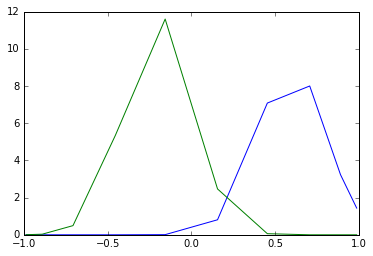

In [20]:
# create measurements    
measurements = np.zeros([Nx] + [Ny]*M)
idx = [i for i in range(Ny)]
for i, p in enumerate(measurePoints):
    for mu_y in iter.product(*[idx]*M):
        measurements[(i,)+tuple(mu_y)] = (kl(mx[p], true_y) - kl(mx[p], list([my[mu_y[k]] for k in range(M)])))**2

# evaluate exponential of inner product
y_measurements = np.sum(measurements, axis=0)
likelihood = np.exp(-0.5*y_measurements)

y_int, mean = integrate_ydims(likelihood, pi_y)

plt.figure(1)
for yi in y_int.T:
    plt.plot(my, yi/mean)
plt.show()

Use a TT-decomposition of the KL and stay in TT-format during computation. Switch to a Full Tensor only to do the integration.

Time consumption for 3 coefficients with 100 grid points in every dimensions: < 2 seconds

Time consumption depends on the number of grid and measure points. For a lot of measure points, the calculation of the inner product takes the most time. For only few, the euler method is most time consuming.

It is possible to speed up the inner product calculation by use of orthogonality.

Testrun : 10 coefficients, grid 100x100, 50% measurepoints => estimation exact, time = $\pi$ min


Create Tensor
Apply Observation
Create Values
Apply Inner Product
Start Euler
Calculate marginal densities


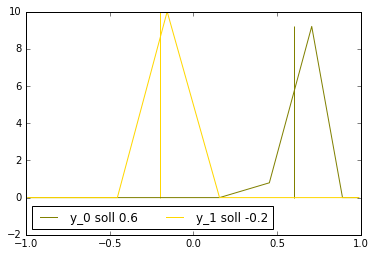

In [21]:
print "Create Tensor"
solution = bayes_lib_simple.create_tensor_from_solution(a, mx, [my for lia in range(len(true_y))])

print "Apply Observation"
solution = bayes_lib_simple.apply_observation(solution, measurePoints, _precision=1e-10, _maxrank=100, _print=True)

print "Create Values"
valueList = [kl(mx[measurePoints[lia]],true_y) for lia in range(len(measurePoints))]
for lia in range(len(solution)):   
    value = bayes_lib_simple.create_rank_one(valueList[lia], solution[lia].n)
    solution[lia] =  value - solution[lia] 

print "Apply Inner Product"
solution = -0.5*bayes_lib_simple.apply_inner_product(solution, _precision=1e-10, _maxrank=100, _print=False, _gamma=0.05)

print "Start Euler"
solution = bayes_lib.exp_euler(solution, 1000, 1e-6, 10, _print=False)

print "Calculate marginal densities"
y_int, Z = bayes_lib_simple.integrate_ydims_tt(solution, pi_y, dy, my)

for i, yi in enumerate(y_int.T):
    plt.plot(my, yi/Z/2, label="y_{0} soll {1}".format(i,true_y[i]), color=color_list[i%len(color_list)])
    plt.vlines(true_y[i],0,max(yi/Z/2),color=color_list[i%len(color_list)])
    plt.legend(ncol = len(y_int.T), loc=3)
plt.show()


Use an interpolation at the end to discribe the densities in terms of Lagrange polynomials. This Approach reduces the amount of stochastical grid points needed, drastically.

In [5]:
y_int_poly,Z = bayes_lib_simple.density_estimation(a,mx,my,true_y,measurePoints,1e-6,eval_grid,10,100,1e-6,10,pi_y,dy,_print=False)


for i, yi in enumerate(y_int_poly):
    plt.plot(eval_grid, yi/Z/2, label="y_{0} soll {1}".format(i,true_y[i]), color=color_list[i%len(color_list)])
    plt.vlines(true_y[i],0,max(yi/Z/2),color=color_list[i%len(color_list)])
    plt.legend(ncol = len(y_int_poly), loc=3)
plt.show()

round tensor of rank [ 1 49 49 49 49 49  1]
tensor rounded to rank [ 1  1 10 10 10 10  1]
round tensor of rank [ 1 50 59 59 59 59  1]
tensor rounded to rank [1 1 3 3 3 3 1]
round tensor of rank [ 1 50 52 52 52 52  1]
tensor rounded to rank [1 1 3 4 4 3 1]
round tensor of rank [ 1 50 52 53 53 52  1]
tensor rounded to rank [1 1 3 4 4 3 1]
round tensor of rank [ 1 50 52 53 53 52  1]
tensor rounded to rank [1 1 3 4 4 3 1]
round tensor of rank [ 1 50 52 53 53 52  1]
tensor rounded to rank [1 1 3 4 4 3 1]
round tensor of rank [ 1 50 52 53 53 52  1]
tensor rounded to rank [1 1 3 4 4 3 1]
round tensor of rank [ 1 50 52 53 53 52  1]
tensor rounded to rank [1 1 3 4 4 3 1]
round tensor of rank [ 1 50 52 53 53 52  1]
tensor rounded to rank [1 1 3 4 4 3 1]
round tensor of rank [ 1 50 52 53 53 52  1]
tensor rounded to rank [1 1 3 4 4 3 1]
round tensor of rank [ 1 50 52 53 53 52  1]
tensor rounded to rank [1 1 3 4 4 3 1]
round tensor of rank [ 1 50 52 53 53 52  1]
tensor rounded to rank [1 1 3 4 4 3 

AssertionError: 